In [1]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Load in the data

In [2]:
house_prices_train = pd.read_csv('train.csv')
house_prices_test = pd.read_csv('test.csv')
house_prices_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
house_prices_train.shape, house_prices_test.shape

((1460, 81), (1459, 80))

In [4]:
train = pd.read_csv('train_human_analog.csv')
test = pd.read_csv('test_human_analog.csv')
output = pd.read_csv('output_human_analog.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.drop(0,axis=0,inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1456, 403) (1459, 403) (1456, 1)


In [5]:
output.dtypes

log_SalePrice    object
dtype: object

In [6]:
output['log_SalePrice'] = output['log_SalePrice'].astype('float64')
output.dtypes

log_SalePrice    float64
dtype: object

## Random Forest

In [7]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.grid_search import RandomizedSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

### Function to fit model and do Cross Validation for error calculation

In [8]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

### Baseline Model


Model Report
R-Square: 0.976
RMSE : 0.061
cv_score: 
[ 0.87481638  0.8864139   0.84617983  0.87268951  0.85241746]
CV Score : Mean: 0.8665034 | Std: 0.01493494 | Min: 0.8461798 | Max: 0.8864139


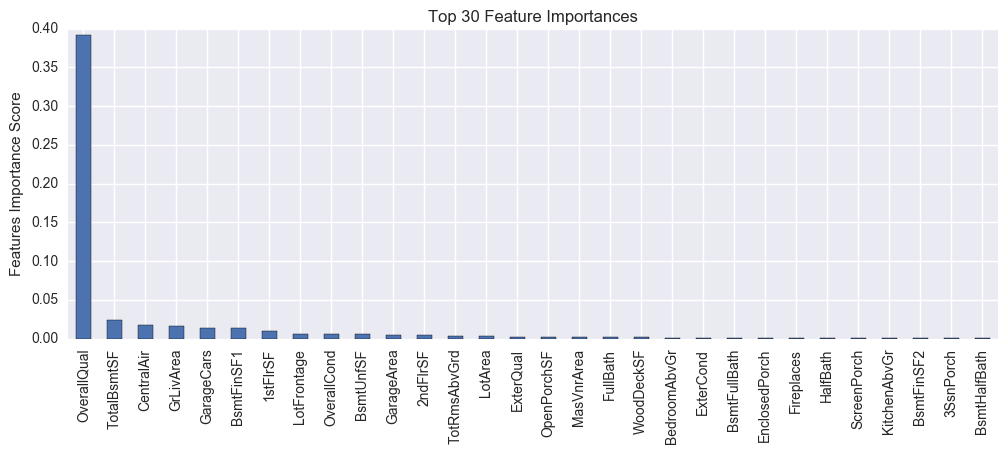

In [9]:
features = train.columns
rf = RandomForestRegressor(random_state=5)
modelfit(rf, train, features, output, performCV=True, printFeatureImportance=True)

### Parameter Tuning

In [10]:
min_samples_split = 0.01  #This should be ~0.5-1% of total values. 
min_samples_leaf = 50 #Can be selected based on intuition. This is just used for preventing overfitting 
max_depth = 3
max_features = 'sqrt' #Its a general thumb-rule to start with square root.

In [11]:
param_test1 = {'n_estimators': range(20,501,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=min_samples_split, 
                                                              min_samples_leaf=min_samples_leaf,
                                                              max_depth=max_depth,
                                                              max_features=max_features,
                                                              random_state=5), 
                                                              param_grid = param_test1, n_jobs=4,iid=False,cv=5)

In [12]:
gsearch1.fit(train[features], output)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=50,
           min_samples_split=0.01, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=5,
           verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [13]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.71568, std: 0.00968, params: {'n_estimators': 20},
  mean: 0.71681, std: 0.01006, params: {'n_estimators': 30},
  mean: 0.72278, std: 0.01084, params: {'n_estimators': 40},
  mean: 0.72070, std: 0.01053, params: {'n_estimators': 50},
  mean: 0.71981, std: 0.00980, params: {'n_estimators': 60},
  mean: 0.71802, std: 0.00889, params: {'n_estimators': 70},
  mean: 0.71920, std: 0.00960, params: {'n_estimators': 80},
  mean: 0.72143, std: 0.01021, params: {'n_estimators': 90},
  mean: 0.72109, std: 0.00866, params: {'n_estimators': 100},
  mean: 0.72203, std: 0.00918, params: {'n_estimators': 110},
  mean: 0.72457, std: 0.00898, params: {'n_estimators': 120},
  mean: 0.72594, std: 0.00947, params: {'n_estimators': 130},
  mean: 0.72520, std: 0.00936, params: {'n_estimators': 140},
  mean: 0.72405, std: 0.00956, params: {'n_estimators': 150},
  mean: 0.72412, std: 0.01033, params: {'n_estimators': 160},
  mean: 0.72487, std: 0.01039, params: {'n_estimators': 170},
  mean: 0.72501,

### Tuning tree-specific parameters

Now lets move onto tuning the tree parameters. I plan to do this in following stages:

Tune max_depth and num_samples_split
Tune min_samples_leaf
Tune max_features

In [14]:
gsearch1.best_params_['n_estimators']

490

In [15]:
param_test2 = {'max_depth': range(1,16,2), 'min_samples_split': np.arange(0.001, 0.011, 0.001)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(min_samples_leaf=min_samples_leaf,
                                                              max_features=max_features,
                                                              n_estimators=gsearch1.best_params_['n_estimators'],
                                                              random_state=5), 
                                                              param_grid = param_test2, n_jobs=4,iid=False,cv=5)
gsearch2.fit(train[features],output)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.002, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0030000000000000001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0040000000000000001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0050000000000000001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0060000000000000001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0070000000000000001, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0080000000000000002, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.0090000000000000011, 'max_depth': 1},
  mean: 0.49387, std: 0.01265, params: {'min_samples_split': 0.010000000000000002, 'max_depth': 1},
  mean: 0.72890, std: 0

In [16]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = min_samples_leaf 
max_depth = gsearch2.best_params_['max_depth']
max_features = 'sqrt'
n_estimators=gsearch1.best_params_['n_estimators'] 

In [17]:
param_test3 = {'min_samples_leaf':range(10,101,10), 'max_features':range(7,30,2)}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=min_samples_split,
                                                              max_depth=max_depth,
                                                              n_estimators=n_estimators,
                                                              random_state=5), 
                                                              param_grid = param_test3, n_jobs=4,iid=False,cv=5)
gsearch3.fit(train[features], output)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.77817, std: 0.01012, params: {'max_features': 7, 'min_samples_leaf': 10},
  mean: 0.74230, std: 0.01315, params: {'max_features': 7, 'min_samples_leaf': 20},
  mean: 0.71119, std: 0.01286, params: {'max_features': 7, 'min_samples_leaf': 30},
  mean: 0.68148, std: 0.01303, params: {'max_features': 7, 'min_samples_leaf': 40},
  mean: 0.65600, std: 0.01454, params: {'max_features': 7, 'min_samples_leaf': 50},
  mean: 0.62748, std: 0.01243, params: {'max_features': 7, 'min_samples_leaf': 60},
  mean: 0.59835, std: 0.01234, params: {'max_features': 7, 'min_samples_leaf': 70},
  mean: 0.57395, std: 0.01261, params: {'max_features': 7, 'min_samples_leaf': 80},
  mean: 0.55669, std: 0.01163, params: {'max_features': 7, 'min_samples_leaf': 90},
  mean: 0.54096, std: 0.01206, params: {'max_features': 7, 'min_samples_leaf': 100},
  mean: 0.80124, std: 0.01136, params: {'max_features': 9, 'min_samples_leaf': 10},
  mean: 0.76874, std: 0.01217, params: {'max_features': 9, 'min_samples_lea

#### Optimum parameters so far: 

In [18]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = gsearch2.best_params_['max_depth']
max_features = gsearch3.best_params_['max_features']
n_estimators=gsearch1.best_params_['n_estimators'] 


Model Report
R-Square: 0.893
RMSE : 0.130
cv_score: 
[ 0.875187    0.8568935   0.8454094   0.84367858  0.85421242]
CV Score : Mean: 0.8550762 | Std: 0.0112414 | Min: 0.8436786 | Max: 0.875187


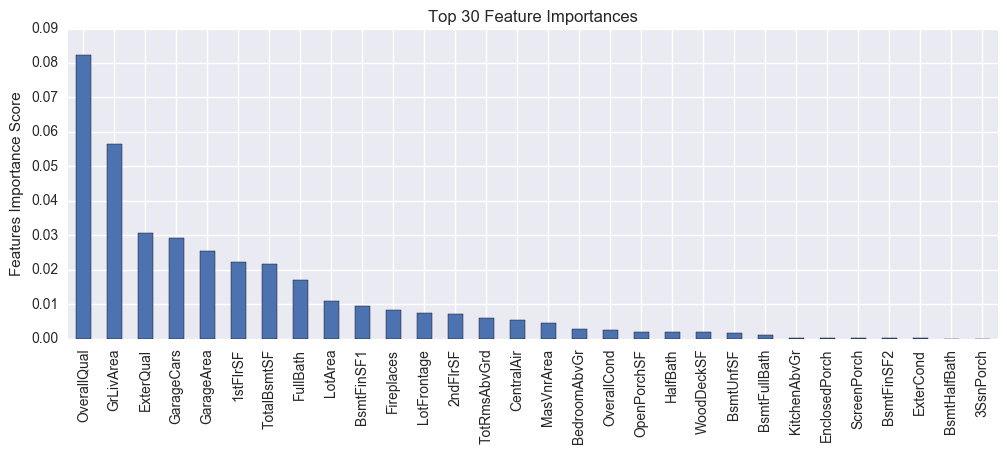

In [19]:
modelfit(gsearch3.best_estimator_, train, features, output)

In [20]:
pred = np.expm1(gsearch3.best_estimator_.predict(test))
rf_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
rf_prediction.head(5)

,Id,SalePrice
0,1461,128272.050731
1,1462,145821.428035
2,1463,182613.121114
3,1464,185677.184118
4,1465,198844.892345


### Lets stack this with Lasso

In [21]:
lasso_pred = pd.read_csv('kaggle_submission_lasso_01012017.csv')

In [24]:
rf_lasso = lasso_pred['SalePrice'].values * 0.5 + pred * 0.5

In [25]:
rf_lasso_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': rf_lasso})
rf_lasso_prediction.head(5)

,Id,SalePrice
0,1461,125001.933136
1,1462,151105.028518
2,1463,181163.154671
3,1464,191091.480671
4,1465,198845.874390


In [26]:
rf_lasso_prediction.to_csv('kaggle_submission_rf_lasso_01012017.csv', index=False)